In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import *

tf.keras.backend.clear_session()

# cam path
seq_model_path = '/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/model_checkpoints/ChemBERTa_DeepChem/run_3/sequence_checkpoint-01-0.69.hdf5'
img_model_path = '/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/model_checkpoints/SMILES_CNN.hdf5'


In [ ]:
seq_model = tf.keras.models.load_model(seq_model_path)
img_model = tf.keras.models.load_model(img_model_path)

models = [seq_model.output, img_model.output]

seq_model._name = 'sequence_mod'
img_model._name = 'image_mod'

seq_model_embedding = Model(inputs=seq_model.input, outputs=seq_model.layers[-2].output)
img_model_embedding = Model(inputs=img_model.input, outputs=img_model.layers[-2].output)

x = Dense(64)(img_model_embedding.output)
img_model_shrunk = Model(inputs=img_model_embedding.input, outputs=x)

# defining input layers for the two submodels
sequence_input = tf.keras.layers.Input(shape=(None, 1))
sequence_input._name = 'seq_input'
# image_input = tf.keras.layers.Input(shape=(x_train_images.shape[1], x_train_images.shape[2], 3))
image_input = tf.keras.layers.Input(shape=(300, 300, 3))
image_input._name = 'img_input'

# defining composite model
seq_model_base_output = seq_model_embedding(sequence_input)
img_model_base_output = img_model_shrunk(image_input)

ensemble_layer = keras.layers.Concatenate()([seq_model_base_output, img_model_base_output])
intermed_layer = Dense(32, activation='relu', kernel_regularizer='l2')(ensemble_layer)
output = Dense(2, activation='softmax')(intermed_layer)
ensemble_model = keras.Model(inputs = [sequence_input, image_input], outputs = output)

ensemble_model.layers[0]._name = 'sequence_input'
ensemble_model.layers[1]._name = 'image_input'

auc_metric = tf.keras.metrics.AUC()
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
ensemble_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy',auc_metric])

ensemble_model.load_weights('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/model_checkpoints/ensemble/ensemble_model_monday.hdf5')

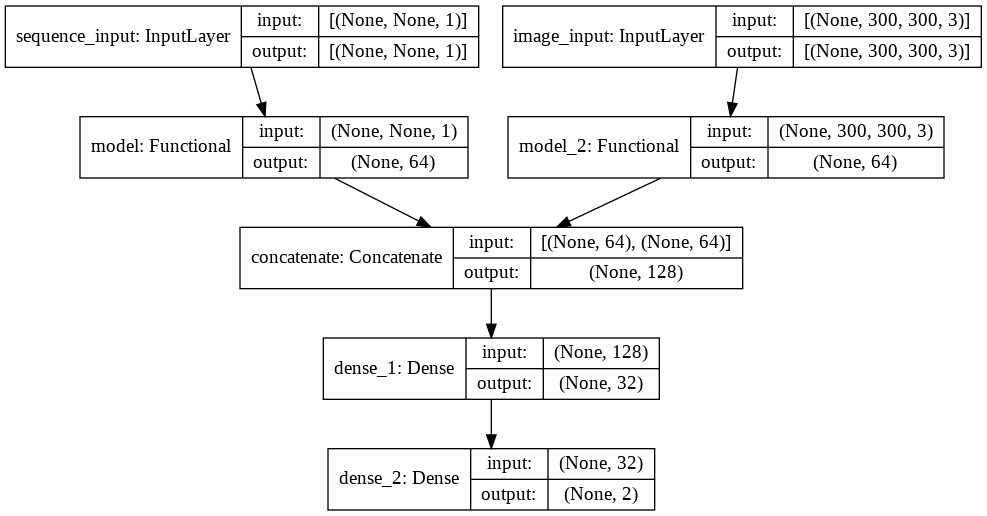

In [ ]:
keras.utils.plot_model(ensemble_model, show_shapes=True)

In [ ]:
import pickle

pickleFile = open('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/model_checkpoints/ensemble/results/ensemble_history_Monday.save', 'rb')
history = pickle.load(pickleFile)

In [ ]:
import plotly.express as px
import pandas as pd

history = pd.DataFrame(history)
history

,loss,accuracy,auc,val_loss,val_accuracy,val_auc,lr
0,0.519555,0.929558,0.936984,4.894881,0.314551,0.210829,0.0050
1,0.304791,0.935256,0.946805,0.289716,0.945078,0.939917,0.0050
2,0.267290,0.935256,0.951735,0.258046,0.945078,0.939935,0.0050
3,0.253998,0.935256,0.950985,0.377010,0.945078,0.939252,0.0050
4,0.244832,0.935428,0.952765,0.236238,0.945792,0.939357,0.0050
5,0.240069,0.935428,0.952955,0.341140,0.945792,0.941993,0.0040
6,0.237877,0.935428,0.954092,0.320485,0.945792,0.941850,0.0040
7,0.234549,0.935428,0.954336,0.232102,0.945792,0.940035,0.0040
8,0.233928,0.935428,0.954966,0.236399,0.945792,0.941782,0.0040
9,0.236936,0.935428,0.951685,0.250838,0.945792,0.938844,0.0032


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=history['loss'], name='Training', mode="lines", opacity=0.7))
fig.add_trace(go.Scatter(y=history['val_loss'], name='Validation', mode="lines", opacity=0.7))
fig.update_layout(title="Training and Validation Loss, Composite", 
                  xaxis_title='Epoch', 
                  yaxis_title='Loss',
                  autosize=False,
                  width=400,
                  height=400)

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history['auc'], name='Training', mode="lines", opacity=0.7))
fig.add_trace(go.Scatter(y=history['val_auc'], name='Validation', mode="lines", opacity=0.7))
fig.update_layout(title="Training and Validation AUROC, Composite", 
                  xaxis_title='Epoch', 
                  yaxis_title='AUC',
                  autosize=False,
                  width=400,
                  height=400)

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history['accuracy'], name='Training', mode="lines", opacity=0.7))
fig.add_trace(go.Scatter(y=history['val_accuracy'], name='Validation', mode="lines", opacity=0.7))
fig.update_layout(title="Training and Validation Accuracy, Composite", 
                  xaxis_title='Epoch', 
                  yaxis_title='Accuracy',
                  autosize=False,
                  width=400,
                  height=400)

fig.show()

In [ ]:
pickleFile = open('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/Data/final_data/x_train_img.save', 'rb')
x_train_img = pickle.load(pickleFile)

pickleFile = open('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/Data/final_data/x_train_seq.save', 'rb')
x_train_seq = pickle.load(pickleFile)

pickleFile = open('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/Data/final_data/y_train.save', 'rb')
y_train = pickle.load(pickleFile)

pickleFile = open('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/Data/final_data/x_val_img.save', 'rb')
x_val_img = pickle.load(pickleFile)

pickleFile = open('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/Data/final_data/x_val_seq.save', 'rb')
x_val_seq = pickle.load(pickleFile)

pickleFile = open('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/Data/final_data/y_val.save', 'rb')
y_val = pickle.load(pickleFile)

pickleFile = open('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/Data/final_data/x_test_img.save', 'rb')
x_test_img = pickle.load(pickleFile)

pickleFile = open('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/Data/final_data/x_test_seq.save', 'rb')
x_test_seq = pickle.load(pickleFile)

pickleFile = open('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/Data/final_data/y_test.save', 'rb')
y_test = pickle.load(pickleFile)

In [ ]:
ensemble_model.evaluate({"sequence_input": x_test_seq, "image_input": x_test_img}, y_test)

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
np.mean(y_test, axis=0)

In [ ]:
np.sum(y_test, axis=0)

In [ ]:
model_cnn = tf.keras.models.load_model('/content/drive/Shareddrives/2040_Final_Project/Molecular Exploration/model_checkpoints/new_SMILES_CNN_auc_07714_30epochs.hdf5')

In [ ]:
model_cnn.evaluate(x_test_img, y_test)

9/9 [==============================] - 8s 464ms/step - loss: 1.9220 - auc: 0.8700 - accuracy: 0.8470


[1.9220163822174072, 0.8700156211853027, 0.8470149040222168]

In [ ]:
from sklearn.metrics import roc_curve
import numpy as np

y_pred_keras = model_cnn.predict(x_test_img)

y_test_1 = np.array([test[1] for test in y_test])
y_pred = np.array([pred[1] for pred in y_pred_keras])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_1, y_pred)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr_keras, y=tpr_keras, 
                         name='ROC', mode="lines", opacity=0.7))
fig.add_trace(go.Scatter(x=np.linspace(0,1,10), y=np.linspace(0,1,10), 
                         name='Baseline', mode="lines", opacity=0.7))
fig.update_layout(title="ROC For CNN Model", 
                  xaxis_title='FPR', 
                  yaxis_title='TPR',
                  autosize=False,
                  width=400,
                  height=400)

fig.show()

In [ ]:
y_pred_bin = np.array([0 if pred < 0.999 else 1 for pred in y_pred])
y_test_1 = y_test_1.astype(int)

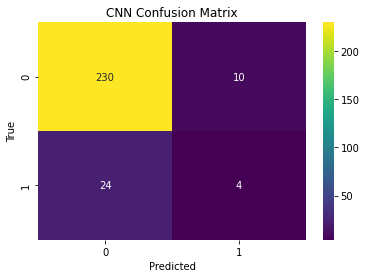

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1, y_pred_bin)
 fig = sns.heatmap(cm1, annot=True, fmt='g', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.show() 

In [ ]:
plot_confusion_matrix(y_test_1, y_pred_bin,
                      range(1),
                      normalize=True, 
                      title="CNN Confusion Matrix")

IndexError: ignored